In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


Image shape:  (1, 256, 256, 1)


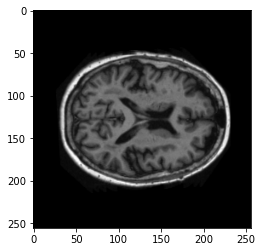

In [83]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

#Define key parameters
batch_size = 50
image_height = 256
image_width = 256
channels = 1 # images are in grayscale
epochs = 50
latent_dims = 128
depth = 32


def create_image(data):
    #Creates a 3D image with extra grayscale channel added
    #4D tensor now
    image = tf.io.decode_png(data, channels=1)
    #normalise the image - float values between 0 and 1
    image = image / 255
    #resize image to 256 x 256
    return tf.image.resize(image, [image_height, image_width], antialias = True)

def get_image_from_file(path):
    #Extract file contents
    raw_data = tf.io.read_file(path)
    image = create_image(raw_data)
    return image

def set_dataset_parameters(dataset):
    # Make sure the dataset is in batches, well-shuffled and prefetches the information
    dataset = dataset.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_train_test_dataset(path_to_training_folder, path_to_test_folder):
    
    # Example path = 'H:\keras_png_slices_data\keras_png_slices_train\*'
    # Example training test_dir path = 'H:\keras_png_slices_data\keras_png_slices_test\*'
    
    # Create the training and testing datasets from the list of files
    training_files = tf.data.Dataset.list_files(path_to_training_folder, shuffle=False)
    test_files = tf.data.Dataset.list_files(path_to_test_folder, shuffle=False)

    #Retreive the size of each dataset
    num_train_images = training_files.cardinality().numpy()
    num_test_images = test_files.cardinality().numpy()
        
    # Shuffle the files
    training_files = training_files.shuffle(num_train_images, reshuffle_each_iteration=True)
    test_files = test_files.shuffle(num_test_images, reshuffle_each_iteration=True)

    # Map the filenames to images inside each dataset
    x_train = training_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)
    x_test = test_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)

    # Finalise data set configurations
    x_train = set_dataset_parameters(x_train)
    x_test2 = x_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(544)
    x_test = set_dataset_parameters(x_test)   
    
    #Return the datasets
    return x_train, x_test, x_test2


training_ds, testing_ds_unbatched, testing_ds_batched = create_train_test_dataset('H:\keras_png_slices_data\keras_png_slices_train\*','H:\keras_png_slices_data\keras_png_slices_test\*')

#Check the dataset was created correctly
example_batch = training_ds.take(1)
ex_image = 0
for element in example_batch:
    for image in element:
        ex_image = image[tf.newaxis, :]
        break
    break

print("Image shape: ", ex_image.numpy().shape)
plt.imshow(ex_image[0, :, :, 0], cmap='gray')


In [22]:
print(ex_image.shape)
flattened = tf.reshape(ex_image, [-1, 1])
print(flattened.shape)

(1, 256, 256, 1)
(65536, 1)


In [84]:
#VQ-VAE parameters from the paper
beta = 0.25 #commitment loss weighting - based on the paper
K = 512 #Number of codebook vectors / embeddings number - using recommended value in the paper

# Vector Quantizer Layer
class Vector_Quantizer(tf.keras.layers.Layer):
    
    def __init__(self):
        super().__init__()
        #define the size of our embeddings - has same length as latent space vectors, and width as defined by K (hyperparameter)
        codebook_shape = (latent_dims, K)
        #create the embedding object - initialise uniformly
        initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        #Declare our embeddings as a tensorflow variable that will be learnt
        self._embeddings = tf.Variable(initializer(shape=codebook_shape, dtype='float32'), trainable = True)

    def quantize_vectors(self, vectors):
        #First need to calculate the distance between our input vectors and every vector in the codebook
        # Paper uses L2 norm: sqrt((x2-x1)^2 + (y2-y1)^2 +...)
        distances = tf.reduce_sum(vectors**2, axis=1, keepdims=True) - 2*tf.matmul(vectors, self._embeddings) + tf.reduce_sum(self._embeddings**2, axis=0, keepdims=True) 

        # Can now determine to which codebook vector our input vectors are closest to (minimum distance)
        indices = tf.argmin(distances, 1)
        
        #Do one-hot encoding so that only the closest codebook vector is mapped to a 1, all others to a 0
        one_hot_indices = tf.one_hot(indices, K)
        
        # Apply indices to the embeddings - now have quantized the vectors
        quantized_vectors = tf.matmul(one_hot_indices, self._embeddings, transpose_b=True)
        
        return quantized_vectors

    def call(self, encoder_outputs):
        #Flatten all dimensions of the encoded vectors except the channels
        #Encoded vectors = (B,H,W,C) -> (B*H*W, C) i.e. flattened, each of which will be quantized independently
        encoded_vectors = tf.reshape(encoder_outputs, [-1, latent_dims])

        #Now can quantize each
        quantized_vectors = self.quantize_vectors(encoded_vectors)
        
        # Reshape the flat vectors back into 2D for use in the convolutional decoder network
        reshaped_quantized_vectors = tf.reshape(quantized_vectors, tf.shape(encoder_outputs))
        
        #Do straight-through estimation so that back-propagation can occur
        # Going forward, output = encoder_output + quantized_vectors - encoder_output = quantized vectors (as desired)
        # Going backward, we copy the gradients at the decoder back to the encoder
        output = encoder_outputs + tf.stop_gradient(reshaped_quantized_vectors - encoder_outputs)
        return output, reshaped_quantized_vectors

In [85]:
# Define the encoder and decoder networks
def encoder_network():

    # Encoder network - takes input images and encodes them into z
    inputs = tf.keras.layers.Input(shape=(image_height, image_width, channels))
    
    # First downsample by half
    conv = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding = "same")(inputs)
    #Second downsample by half
    conv = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding = "same")(conv)
    #Third downsample by half
    #conv = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, activation='relu', padding = "same")(conv)
    
    #Final conv layer - image is now encoded into size of latent space
    output = tf.keras.layers.Conv2D(latent_dims, kernel_size = 1, padding = "same")(conv) #******************

    # Build the encoder
    final_network = tf.keras.Model(inputs, output, name="Encoder")

    return final_network

def decoder_network():
    # Takes the latent space and upsamples until original size is reached
    #256 -> downsampled twice = 256/4 = 64
    inputs = tf.keras.layers.Input(shape=(64,64,latent_dims))
    #input_shape = encoder().output.shape[1:]
    #inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Now can upsample twice
    conv = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    conv = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu')(conv)
    
    #Output layer
    output = tf.keras.layers.Conv2D(1,kernel_size=[1,1], strides=1, activation='relu', padding = "same")(conv)
    
    #build the decoder
    final_network = tf.keras.Model(inputs, output, name="Decoder")
    return final_network


In [5]:
encoder = encoder_network()
print(encoder.summary())

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       8320      
Total params: 27,136
Trainable params: 27,136
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
decoder = decoder_network()
print(decoder.summary())

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 128)]     0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 32)      36896     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 16)      4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 1)       17        
Total params: 41,537
Trainable params: 41,537
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
def reconstruction_loss(inputs, outputs):    
    #Calculate ssim to use as reconstruction loss - better than mse which is thrown off by the large background
    loss = 1 - tf.image.ssim(inputs, outputs, max_val = 1)
    
    return loss

#Replace kl-divergence in traditional VAE with two terms as kl-divergence can't be minimized (is a constant)
def latent_loss(encoder_output, quantized_vectors):
    # latent commitment loss
    # beta*||z_e(x)-sg[e]|| i.e. freeze the codebook vectors/embeddings and push the encoded vectors towards codebook vectors
    mse1 = tf.keras.losses.MeanSquaredError()
    e_loss = beta * mse1(tf.stop_gradient(quantized_vectors), encoder_output)

    # latent codebook loss
    #||sg[z_e(x)]-e|| i.e. freeze the encoded vectors and push codebook vectors to encoded vectors
    mse2 = tf.keras.losses.MeanSquaredError()
    q_loss = mse2(quantized_vectors, tf.stop_gradient(encoder_output))
    
    return q_loss + e_loss

In [87]:
#Create the encoder and decoder components of VQ-VAE Model
encoder = encoder_network()
decoder = decoder_network()
quantizer_layer = Vector_Quantizer()

#Create overall vqvae model
inputs = tf.keras.Input(shape=(256, 256, 1))
encoder_outputs = encoder(inputs)
quantized_latents,z1 = quantizer_layer(encoder_outputs)
reconstructions = decoder(quantized_latents)
vq_vae_model_overall = tf.keras.Model(inputs, reconstructions, name="overall model")

optimizer = tf.keras.optimizers.Adam(1e-4)

# create a training step
@tf.function
def training_step(images):
    with tf.GradientTape(persistent=True) as vae_tape:
        #Get the latent space
        z = encoder(images, training=True)
        #Get the quantized latent space
        z_quantized, z1 = quantizer_layer(z, training=True)
        #Get the reconstructions
        
        #print(z[0])
        #print(z1[0])
        reconstructions = decoder(z_quantized, training=True)        

        #determine overall loss: recon_loss + latent_loss
        recon_loss = tf.reduce_mean(reconstruction_loss(images, reconstructions) )
        #recon_loss = reconstruction_loss(images, reconstructions)
        latent_loss1 = tf.reduce_mean(latent_loss(z, z1))
        
        total_loss = recon_loss + latent_loss1    
    
    gradients = vae_tape.gradient(total_loss, vq_vae_model_overall.trainable_variables)
    
    #apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, vq_vae_model_overall.trainable_variables))
    
    return recon_loss, latent_loss1, total_loss

In [ ]:
# Training
recon_loss_list = []
latent_loss_list = []

losses = []
for epoch in range(1, epochs+1):
    print(epoch)
    loss = -1
    batch_losses = 0
    
    batch_losses_recon = 0
    batch_losses_latent = 0
    
    count = 0
        
    for image_batch in training_ds:
        
        recon_loss, latent_loss_results, total_loss = training_step(image_batch)
        
        #print(recon_loss.numpy())
        #print(latent_loss_results.numpy())
        #print(total_loss.numpy())

        batch_losses += total_loss
        batch_losses_recon += recon_loss
        batch_losses_latent += latent_loss_results
        count += 1 
        
        losses.append(batch_losses/count)
        recon_loss_list.append(batch_losses_recon/count)
        latent_loss_list.append(batch_losses_latent/count)


1
2
3
4
5
6
7
8
9
10
11
12
13
14


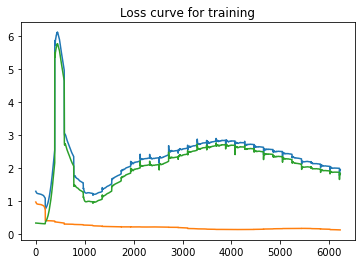

In [81]:
plt.title('Loss curve for training')
plt.plot(losses)
plt.plot(recon_loss_list)
plt.plot(latent_loss_list)

plt.show()

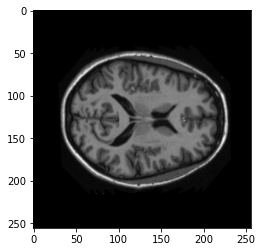

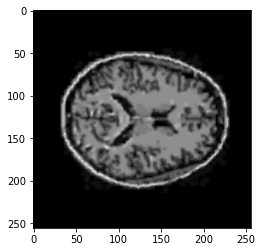

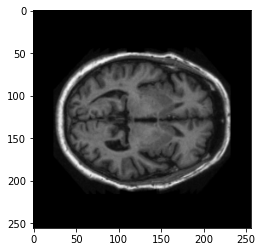

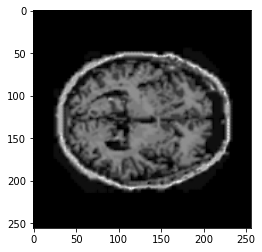

[0.87439334]


In [82]:
test_batch = testing_ds_batched.take(1)
train_batch = training_ds.take(1)
test_image = 0
train_image = 0
for element in test_batch:
    for image in element:
        test_image = image[tf.newaxis, :]
        break
    break

for element in train_batch:
    for image in element:
        train_image = image[tf.newaxis, :]
        break
    break

z = encoder(test_image, training=False)
#Get the quantized latent space
z_quantized, z1 = quantizer_layer(z, training=False)
#Get the reconstructions
result = decoder(z_quantized, training=False)

#Plot the resulting image compared to original
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.show()
plt.imshow(result[0, :, :, 0], cmap='gray')
plt.show()

z = encoder(train_image, training=False)
#Get the quantized latent space
z_quantized, z1 = quantizer_layer(z, training=False)
#Get the reconstructions
result = decoder(z_quantized, training=False)

#Plot the resulting image compared to original
plt.imshow(train_image[0, :, :, 0], cmap='gray')
plt.show()
plt.imshow(result[0, :, :, 0], cmap='gray')
plt.show()


ssim = tf.image.ssim(train_image, result, max_val = 1)
print(ssim.numpy())
